# Trading Strategies (b)

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
import warnings

In [2]:
warnings.simplefilter('ignore')
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.random.seed(1000)
%matplotlib inline

## Linear OLS Regression

### The Data

In [3]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)

In [4]:
raw.columns

Index(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX',
       'EUR=', 'XAU=', 'GDX', 'GLD'],
      dtype='object')

In [5]:
symbol = 'EUR='

In [6]:
data = pd.DataFrame(raw[symbol])

In [7]:
data['returns'] = np.log(data / data.shift(1))

In [8]:
data.dropna(inplace=True)

In [9]:
data['direction'] = np.sign(data['returns']).astype(int)

In [10]:
data.head()

,EUR=,returns,direction
Date,,,
2010-01-04,1.4411,0.006125,1
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1


In [11]:
data['direction'].value_counts()

 1    1111
-1    1093
 0      11
Name: direction, dtype: int64

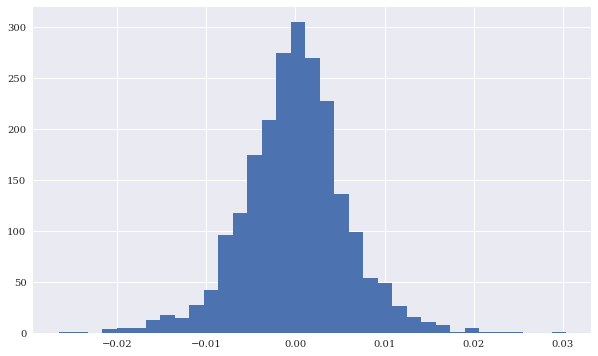

In [12]:
data['returns'].hist(bins=35, figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_01.png')

In [13]:
lags = 2

In [14]:
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)

In [15]:
create_lags(data)

In [16]:
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-04,1.4411,0.006125,1,NaN,NaN
2010-01-05,1.4368,-0.002988,-1,0.006125,NaN
2010-01-06,1.4412,0.003058,1,-0.002988,0.006125
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058


In [17]:
data.dropna(inplace=True)

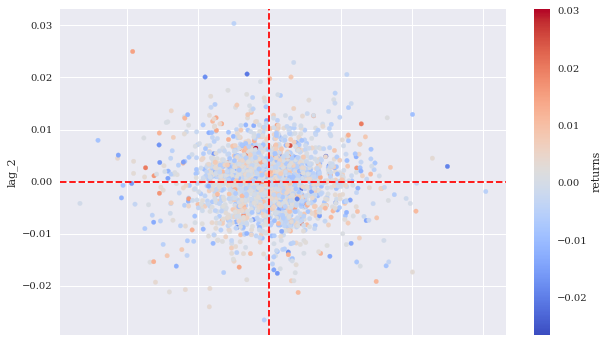

In [18]:
data.plot.scatter(x='lag_1', y='lag_2', c='returns', 
                  cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--');
# plt.savefig('../../images/ch15/strat_ml_02.png');

### Regression

In [19]:
from sklearn.linear_model import LinearRegression  

In [20]:
model = LinearRegression()  

In [21]:
data['pos_ols_1'] = model.fit(data[cols], data['returns']).predict(data[cols])  

In [22]:
data['pos_ols_2'] = model.fit(data[cols], data['direction']).predict(data[cols])  

In [23]:
data[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
Date,,
2010-01-06,-0.000002,-0.000663
2010-01-07,-0.000164,0.001545
2010-01-08,0.000030,0.032971
2010-01-11,-0.000245,-0.004227
2010-01-12,-0.000154,-0.061068


In [24]:
data[['pos_ols_1', 'pos_ols_2']] = np.where(
            data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)  

In [25]:
data['pos_ols_1'].value_counts()  

-1    1863
 1     350
Name: pos_ols_1, dtype: int64

In [26]:
data['pos_ols_2'].value_counts()  

 1    1310
-1     903
Name: pos_ols_2, dtype: int64

In [27]:
pd.crosstab(data['pos_ols_1'],data['pos_ols_2'], rownames = ['pos_ols_1'],
            colnames = ['pos_ols_2'])

pos_ols_2,-1,1
pos_ols_1,,
-1,851,1012
1,52,298


In [28]:
(data['pos_ols_1'].diff() != 0).sum()  

653

In [29]:
(data['pos_ols_2'].diff() != 0).sum()  

766

In [30]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']

In [31]:
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

In [32]:
data

,EUR=,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2
Date,,,,,,,,,
2010-01-06,1.4412,0.003058,1,-0.002988,0.006125,-1,-1,-0.003058,-0.003058
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988,-1,1,0.006544,-0.006544
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,1,1,0.006544,0.006544
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,-1,-1,-0.006984,-0.006984
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-1,-1,0.001310,0.001310
...,...,...,...,...,...,...,...,...,...
2018-06-25,1.1702,0.004024,1,0.004644,0.002676,-1,-1,-0.004024,-0.004024
2018-06-26,1.1645,-0.004883,-1,0.004024,0.004644,-1,-1,0.004883,0.004883
2018-06-27,1.1552,-0.008018,-1,-0.004883,0.004024,1,1,-0.008018,-0.008018


In [33]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

returns        0.813126
strat_ols_1    0.987177
strat_ols_2    1.287336
dtype: float64

In [34]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].std() * np.sqrt(252)

returns        0.092533
strat_ols_1    0.092545
strat_ols_2    0.092527
dtype: float64

In [35]:
(data['direction'] == data['pos_ols_1']).value_counts()  

False    1132
True     1081
dtype: int64

In [36]:
(data['direction'] == data['pos_ols_2']).value_counts()  

True     1145
False    1068
dtype: int64

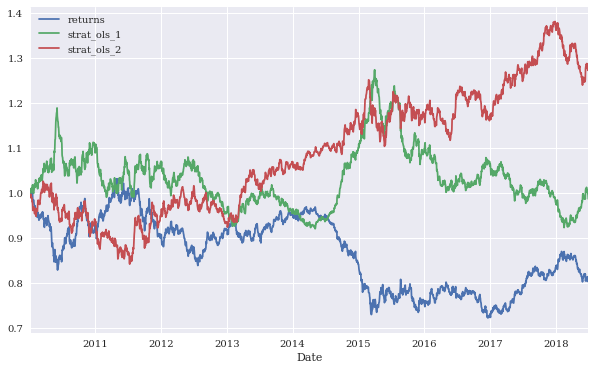

In [37]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_03.png');

## Clustering

In [38]:
from sklearn.cluster import KMeans

In [39]:
model = KMeans(n_clusters=2, random_state=0)  #  Two clusters are chosen for the algorithm.

In [40]:
model.fit(data[cols])

KMeans(n_clusters=2, random_state=0)

In [41]:
data['pos_clus'] = model.predict(data[cols])

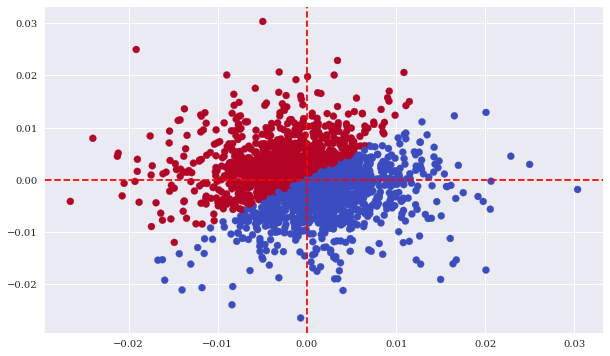

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(data[cols].iloc[:, 0], data[cols].iloc[:, 1],
            c=data['pos_clus'], cmap='coolwarm');
plt.axvline(0, c='r', ls = '--')
plt.axhline(0, c='r', ls = '--')
# plt.savefig('../../images/ch15/strat_ml_04.png');

In [43]:
pd.crosstab(data['direction'],data['pos_clus'], rownames = ['direction'],
            colnames = ['pos_clus'])

pos_clus,0,1
direction,,
-1,592,500
0,6,5
1,596,514


In [44]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2,pos_clus
Date,,,,,,,,,,
2010-01-06,1.4412,0.003058,1,-0.002988,0.006125,-1,-1,-0.003058,-0.003058,1
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988,-1,1,0.006544,-0.006544,0
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,1,1,0.006544,0.006544,1
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,-1,-1,-0.006984,-0.006984,0
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-1,-1,0.001310,0.001310,0


In [45]:
data['pos_clus'] = np.where(data['pos_clus'] == 0, -1, 1)  

In [46]:
data['pos_clus'].values

array([ 1, -1,  1, ...,  1,  1, -1])

In [47]:
data['strat_clus'] = data['pos_clus'] * data['returns']

In [48]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2,pos_clus,strat_clus
Date,,,,,,,,,,,
2010-01-06,1.4412,0.003058,1,-0.002988,0.006125,-1,-1,-0.003058,-0.003058,1,0.003058
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988,-1,1,0.006544,-0.006544,-1,0.006544
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,1,1,0.006544,0.006544,1,0.006544
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,-1,-1,-0.006984,-0.006984,-1,-0.006984
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-1,-1,0.001310,0.001310,-1,0.001310


In [49]:
data[['returns', 'strat_clus']].sum().apply(np.exp)

returns       0.813126
strat_clus    1.166746
dtype: float64

In [50]:
(data['direction'] == data['pos_clus']).value_counts()

False    1107
True     1106
dtype: int64

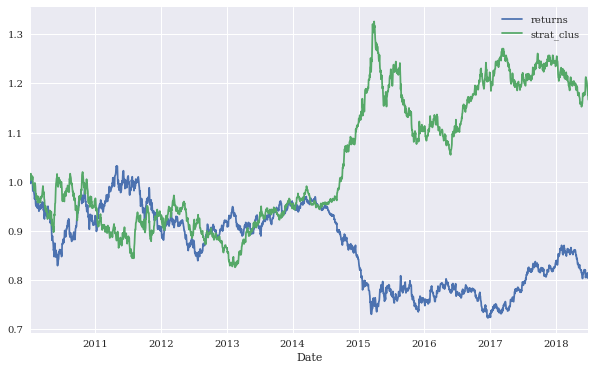

In [51]:
data[['returns', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_05.png');

In [52]:
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)  

In [53]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2,pos_clus,strat_clus
Date,,,,,,,,,,,
2010-01-06,1.4412,0.003058,1,-0.002988,0.006125,-1,-1,-0.003058,-0.003058,-1,0.003058
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988,-1,1,0.006544,-0.006544,1,0.006544
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,1,1,0.006544,0.006544,-1,0.006544
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,-1,-1,-0.006984,-0.006984,1,-0.006984
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-1,-1,0.001310,0.001310,1,0.001310


In [54]:
data['strat_clus'] = data['pos_clus'] * data['returns']

In [55]:
data[['returns', 'strat_clus']].sum().apply(np.exp)

returns       0.813126
strat_clus    0.857084
dtype: float64

In [56]:
(data['direction'] == data['pos_clus']).value_counts()

False    1117
True     1096
dtype: int64

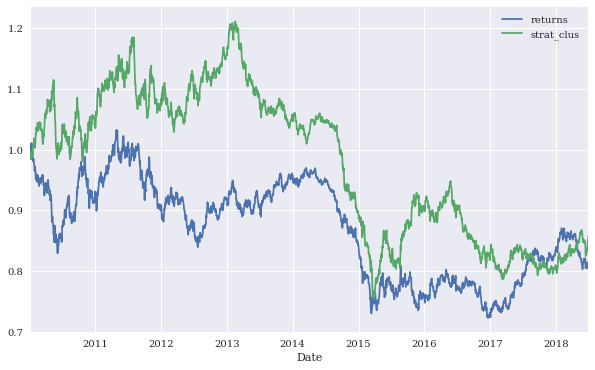

In [57]:
data[['returns', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_05.png');

Apparently, the first one is better

In [58]:
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)  

In [59]:
data['strat_clus'] = data['pos_clus'] * data['returns']

## Frequency Approach

In [60]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2,pos_clus,strat_clus
Date,,,,,,,,,,,
2010-01-06,1.4412,0.003058,1,-0.002988,0.006125,-1,-1,-0.003058,-0.003058,1,0.003058
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988,-1,1,0.006544,-0.006544,-1,0.006544
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,1,1,0.006544,0.006544,1,0.006544
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,-1,-1,-0.006984,-0.006984,-1,-0.006984
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-1,-1,0.001310,0.001310,-1,0.001310


In [61]:
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)

In [62]:
create_bins(data)

In [63]:
data[cols_bin + ['direction']].head()  

,lag_1_bin,lag_2_bin,direction
Date,,,
2010-01-06,0,1,1
2010-01-07,1,0,-1
2010-01-08,0,1,1
2010-01-11,1,0,1
2010-01-12,1,1,-1


In [64]:
data[data['direction']==0].head()

,EUR=,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2,pos_clus,strat_clus,lag_1_bin,lag_2_bin
Date,,,,,,,,,,,,,
2011-12-06,1.3401,0.0,0,-0.000075,-0.004541,-1,1,-0.0,0.0,-1,-0.0,0,0
2012-02-21,1.3239,0.0,0,0.006669,0.000913,-1,-1,-0.0,-0.0,-1,-0.0,1,1
2012-08-07,1.2400,0.0,0,0.001210,0.016691,1,-1,0.0,-0.0,1,0.0,1,1
2013-02-13,1.3453,0.0,0,0.003500,0.003213,-1,-1,-0.0,-0.0,-1,-0.0,1,1
2013-02-22,1.3188,0.0,0,-0.006952,-0.007950,-1,1,-0.0,0.0,-1,-0.0,0,0


In [65]:
data.loc['2011-12-06':'2011-12-8'][['direction']+cols+cols_bin]

,direction,lag_1,lag_2,lag_1_bin,lag_2_bin
Date,,,,,
2011-12-06,0,-0.000075,-0.004541,0,0
2011-12-07,1,0.000000,-0.000075,1,0
2011-12-08,-1,0.000820,0.000000,1,1


In [66]:
grouped = data.groupby(cols_bin + ['direction'])
grouped.size()  

lag_1_bin  lag_2_bin  direction
0          0          -1           237
                       0             4
                       1           276
           1          -1           280
                       0             1
                       1           295
1          0          -1           287
                       0             1
                       1           288
           1          -1           288
                       0             5
                       1           251
dtype: int64

In [67]:
res = grouped['direction'].size().unstack(fill_value=0)  
res

direction             -1   0    1
lag_1_bin lag_2_bin              
0         0          237   4  276
          1          280   1  295
1         0          287   1  288
          1          288   5  251

In [68]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]  

In [69]:
res.style.apply(highlight_max, axis=1)  

In [70]:
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2, -1, 1)  

In [71]:
(data['direction'] == data['pos_freq']).value_counts()

True     1147
False    1066
dtype: int64

In [72]:
data['strat_freq'] = data['pos_freq'] * data['returns']

In [73]:
data[['returns', 'strat_freq']].sum().apply(np.exp)

returns       0.813126
strat_freq    1.016673
dtype: float64

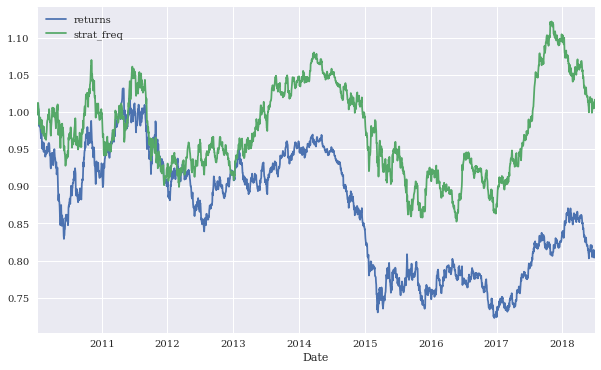

In [74]:
data[['returns', 'strat_freq']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_06.png');

## Classification Algorithms

### Two Binary Features

In [75]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [76]:
C = 1

C越大，越容易出现overfitting

In [77]:
models = {
    'log_reg': linear_model.LogisticRegression(C=C),
    'gauss_nb': GaussianNB(),
    'svm': SVC(C=C)
}

In [78]:
def fit_models(data):  
    mfit = {model: models[model].fit(data[cols_bin], data['direction'])
            for model in models.keys()} 

In [79]:
fit_models(data)

In [80]:
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [81]:
derive_positions(data)

In [82]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2,pos_clus,strat_clus,lag_1_bin,lag_2_bin,pos_freq,strat_freq,pos_log_reg,pos_gauss_nb,pos_svm
Date,,,,,,,,,,,,,,,,,,
2010-01-06,1.4412,0.003058,1,-0.002988,0.006125,-1,-1,-0.003058,-0.003058,1,0.003058,0,1,1,0.003058,1,1,1
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988,-1,1,0.006544,-0.006544,-1,0.006544,1,0,1,-0.006544,-1,-1,1
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,1,1,0.006544,0.006544,1,0.006544,0,1,1,0.006544,1,1,1
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,-1,-1,-0.006984,-0.006984,-1,-0.006984,1,0,1,0.006984,-1,-1,1
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-1,-1,0.001310,0.001310,-1,0.001310,1,1,-1,0.001310,-1,-1,-1


In [83]:
def evaluate_strats(data):  
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_' + model 
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')

In [84]:
evaluate_strats(data)

In [85]:
sel

['returns', 'strat_log_reg', 'strat_gauss_nb', 'strat_svm']

In [86]:
sel.insert(1, 'strat_freq')
sel

['returns', 'strat_freq', 'strat_log_reg', 'strat_gauss_nb', 'strat_svm']

In [87]:
data[sel].sum().apply(np.exp)

returns           0.813126
strat_freq        1.016673
strat_log_reg     1.385460
strat_gauss_nb    1.385460
strat_svm         1.016673
dtype: float64

In [88]:
def accurate_rate(data):
    print ('    Accurate of three methods   ')
    print ('-'*32)
    print ('linear_model  |   %f'  %(data['direction']==data['pos_log_reg']).mean())
    print ('GaussianNB    |   %f'  %(data['direction']==data['pos_gauss_nb']).mean())
    print ('SVC           |   %f' %(data['direction']==data['pos_svm']).mean())
    

In [89]:
accurate_rate(data)

    Accurate of three methods   
--------------------------------
linear_model  |   0.517849
GaussianNB    |   0.517849
SVC           |   0.518301


In [90]:
reward = pd.DataFrame()

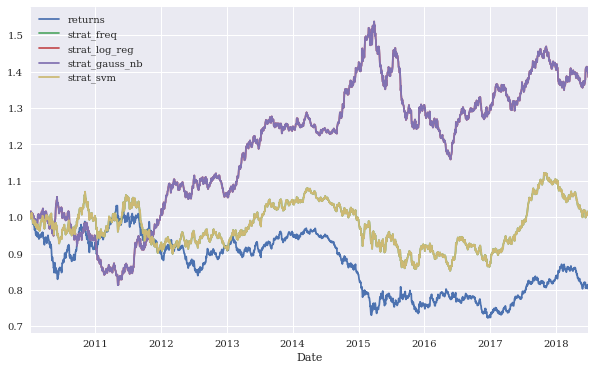

In [91]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_07.png')

### Five Binary Features

In [92]:
data = pd.DataFrame(raw[symbol])

In [93]:
data['returns'] = np.log(data / data.shift(1))

In [94]:
data['direction'] = np.sign(data['returns'])

In [95]:
lags = 5  
create_lags(data)
data.dropna(inplace=True)

In [96]:
create_bins(data)  
cols_bin

['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [97]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-11,1,0,1,0,1
2010-01-12,1,1,0,1,0
2010-01-13,0,1,1,0,1
2010-01-14,1,0,1,1,0
2010-01-15,0,1,0,1,1


In [98]:
data.dropna(inplace=True)

In [99]:
fit_models(data)

In [100]:
derive_positions(data)

In [101]:
evaluate_strats(data)

In [102]:
data[sel].sum().apply(np.exp)

returns           0.810644
strat_log_reg     1.191997
strat_gauss_nb    1.191997
strat_svm         2.364393
dtype: float64

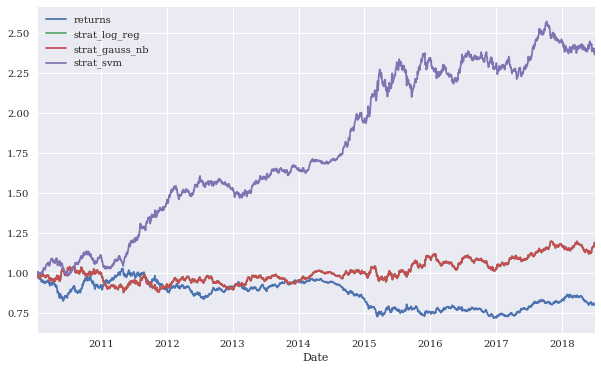

In [103]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_08.png');

In [104]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,lag_3,lag_4,lag_5,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin,pos_log_reg,pos_gauss_nb,pos_svm,strat_log_reg,strat_gauss_nb,strat_svm
Date,,,,,,,,,,,,,,,,,,,
2010-01-11,1.4513,0.006984,1.0,0.006544,-0.006544,0.003058,-0.002988,0.006125,1,0,1,0,1,-1.0,-1.0,1.0,-0.006984,-0.006984,0.006984
2010-01-12,1.4494,-0.001310,-1.0,0.006984,0.006544,-0.006544,0.003058,-0.002988,1,1,0,1,0,-1.0,-1.0,-1.0,0.001310,0.001310,0.001310
2010-01-13,1.4510,0.001103,1.0,-0.001310,0.006984,0.006544,-0.006544,0.003058,0,1,1,0,1,1.0,1.0,1.0,0.001103,0.001103,0.001103
2010-01-14,1.4502,-0.000551,-1.0,0.001103,-0.001310,0.006984,0.006544,-0.006544,1,0,1,1,0,-1.0,-1.0,-1.0,0.000551,0.000551,0.000551
2010-01-15,1.4382,-0.008309,-1.0,-0.000551,0.001103,-0.001310,0.006984,0.006544,0,1,0,1,1,1.0,1.0,1.0,-0.008309,-0.008309,-0.008309


In [105]:
accurate_rate(data)

    Accurate of three methods   
--------------------------------
linear_model  |   0.514932
GaussianNB    |   0.514932
SVC           |   0.544796


### Five Digitized Features

In [106]:
mu = data['returns'].mean()  
v = data['returns'].std()  

In [107]:
bins = [mu - v, mu, mu + v]  
bins  

[-0.005924269398870446, -9.498932088272977e-05, 0.005734290757104987]

In [108]:
create_bins(data, bins)

In [109]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-11,3,0,2,1,3
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3


In [110]:
fit_models(data)

In [111]:
derive_positions(data)

In [112]:
evaluate_strats(data)

In [113]:
data[sel].sum().apply(np.exp)

returns           0.810644
strat_log_reg     1.520599
strat_gauss_nb    1.437281
strat_svm         5.815787
dtype: float64

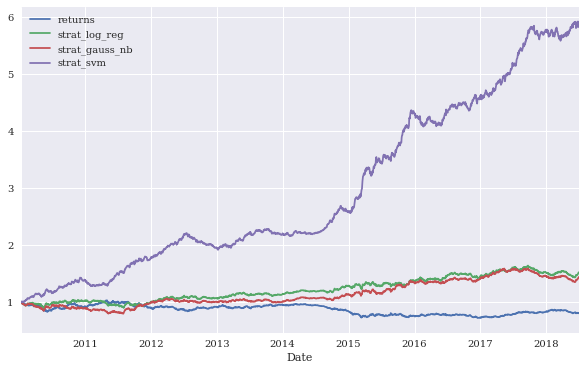

In [114]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_09.png')

In [115]:
accurate_rate(data)

    Accurate of three methods   
--------------------------------
linear_model  |   0.522172
GaussianNB    |   0.515837
SVC           |   0.586878


### Sequential Train-Test Split

https://github.com/blue-yonder/tsfresh

In [116]:
split = int(len(data) * 0.5)

In [117]:
split

1105

In [118]:
train = data.iloc[:split].copy()  

In [119]:
fit_models(train)  

In [120]:
test = data.iloc[split:].copy()  

In [121]:
derive_positions(test)  

In [122]:
evaluate_strats(test)  

In [123]:
test[sel].sum().apply(np.exp)

returns           0.852649
strat_log_reg     1.077934
strat_gauss_nb    1.183389
strat_svm         1.023219
dtype: float64

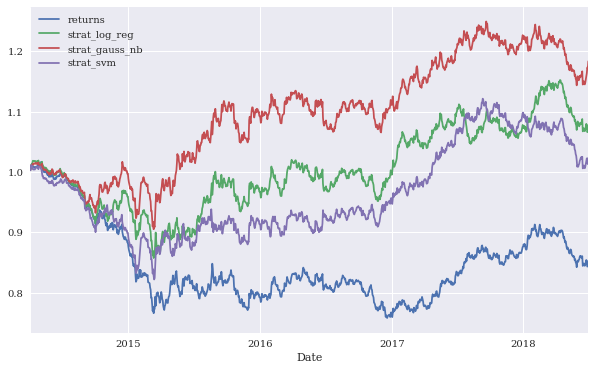

In [124]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_10.png');

In [125]:
accurate_rate(data)

    Accurate of three methods   
--------------------------------
linear_model  |   0.522172
GaussianNB    |   0.515837
SVC           |   0.586878


### Randomized Train-Test Split

In [126]:
from sklearn.model_selection import train_test_split

In [127]:
train, test = train_test_split(data, test_size=0.5,
                               shuffle=True, random_state=100)

In [128]:
train = train.copy().sort_index()  

In [129]:
train[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-11,3,0,2,1,3
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-18,0,1,2,1,3


In [130]:
test = test.copy().sort_index()  

In [131]:
fit_models(train)

In [132]:
derive_positions(test)

In [133]:
evaluate_strats(test)

In [134]:
test[sel].sum().apply(np.exp)

returns           0.736500
strat_log_reg     0.796591
strat_gauss_nb    1.010429
strat_svm         1.148902
dtype: float64

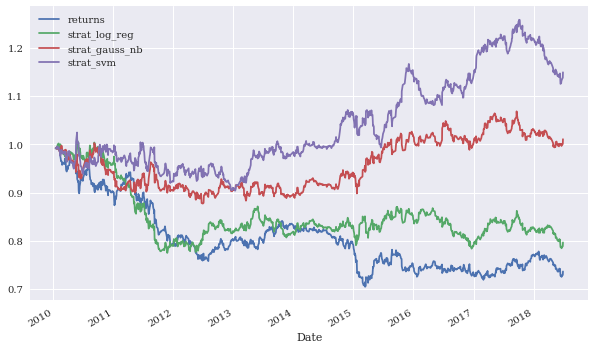

In [135]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_11.png');

In [136]:
accurate_rate(train)

    Accurate of three methods   
--------------------------------
linear_model  |   0.523982
GaussianNB    |   0.518552
SVC           |   0.584615


In [137]:
accurate_rate(test)

    Accurate of three methods   
--------------------------------
linear_model  |   0.493213
GaussianNB    |   0.438914
SVC           |   0.515837


## Deep Neural Network

### DNN with scikit-learn

In [138]:
from sklearn.neural_network import MLPClassifier

In [139]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=2 * [250], random_state=1)

In [140]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,lag_3,lag_4,lag_5,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin,pos_log_reg,pos_gauss_nb,pos_svm,strat_log_reg,strat_gauss_nb,strat_svm
Date,,,,,,,,,,,,,,,,,,,
2010-01-11,1.4513,0.006984,1.0,0.006544,-0.006544,0.003058,-0.002988,0.006125,3,0,2,1,3,-1.0,-1.0,-1.0,-0.006984,-0.006984,-0.006984
2010-01-12,1.4494,-0.001310,-1.0,0.006984,0.006544,-0.006544,0.003058,-0.002988,3,3,0,2,1,-1.0,-1.0,-1.0,0.001310,0.001310,0.001310
2010-01-13,1.4510,0.001103,1.0,-0.001310,0.006984,0.006544,-0.006544,0.003058,1,3,3,0,2,-1.0,-1.0,1.0,-0.001103,-0.001103,0.001103
2010-01-14,1.4502,-0.000551,-1.0,0.001103,-0.001310,0.006984,0.006544,-0.006544,2,1,3,3,0,-1.0,-1.0,-1.0,0.000551,0.000551,0.000551
2010-01-15,1.4382,-0.008309,-1.0,-0.000551,0.001103,-0.001310,0.006984,0.006544,1,2,1,3,3,1.0,1.0,-1.0,-0.008309,-0.008309,0.008309


In [141]:
%time model.fit(data[cols_bin], data['direction'])

CPU times: user 25.1 s, sys: 16.3 s, total: 41.5 s
Wall time: 40.7 s


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[250, 250], random_state=1,
              solver='lbfgs')

In [142]:
data['pos_dnn_sk'] = model.predict(data[cols_bin])

In [143]:
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['returns']

In [144]:
data[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns          0.810644
strat_dnn_sk    34.008778
dtype: float64

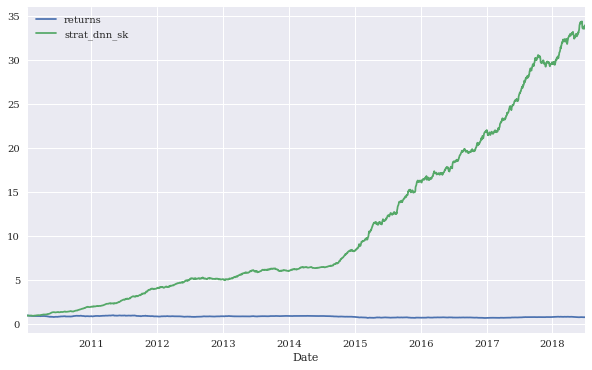

In [145]:
data[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_12.png');

In [146]:
train, test = train_test_split(data, test_size=0.5, random_state=100)

In [147]:
train = train.copy().sort_index()

In [148]:
test = test.copy().sort_index()

In [149]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500,
                     hidden_layer_sizes=3 * [500], random_state=1)  

In [150]:
%time model.fit(train[cols_bin], train['direction'])

CPU times: user 3min 18s, sys: 1min 45s, total: 5min 4s
Wall time: 2min 36s


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[500, 500, 500], max_iter=500,
              random_state=1, solver='lbfgs')

In [151]:
test['pos_dnn_sk'] = model.predict(test[cols_bin])

In [152]:
test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['returns']

In [153]:
test[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns         0.736500
strat_dnn_sk    0.893426
dtype: float64

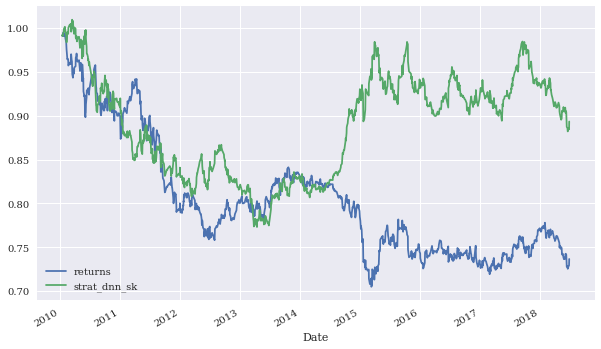

In [154]:
test[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_13.png');

### DNN with Keras & TensorFlow Backend

In [ ]:
!pip install tensorflow

In [156]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential

In [157]:
def create_model():
    np.random.seed(100)
    tf.random.set_seed(100)
    model = Sequential()
    model.add(Dense(16, activation='relu', input_dim=lags))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [158]:
data_ = (data - data.mean()) / data.std()
data['direction_'] = np.where(data['direction'] == 1, 1, 0)

In [159]:
model = create_model()

In [160]:
%%time
model.fit(data_[cols], data['direction_'],
          epochs=50, verbose=False)

CPU times: user 6.93 s, sys: 368 ms, total: 7.3 s
Wall time: 11.1 s


In [161]:
model.evaluate(data_[cols], data['direction_'])

70/70 [==============================] - 1s 4ms/step - loss: 0.6689 - accuracy: 0.5891


[0.6689161062240601, 0.5891402959823608]

In [162]:
pred = np.where(model.predict(data_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

array([1, 0, 0, 0, 1, 0, 0, 1, 1, 1])

In [163]:
data['pos_dnn_ke'] = np.where(pred > 0, 1, -1)  

In [164]:
data['strat_dnn_ke'] = data['pos_dnn_ke'] * data['returns']

In [165]:
data[['returns', 'strat_dnn_ke']].sum().apply(np.exp)

returns         0.810644
strat_dnn_ke    5.977176
dtype: float64

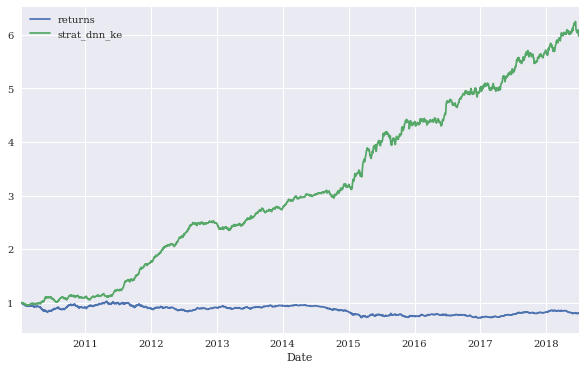

In [166]:
data[['returns', 'strat_dnn_ke']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_14.png');

In [167]:
mu, std = train.mean(), train.std()

In [168]:
train_ = (train - mu) / mu.std()

In [169]:
model = create_model()

In [170]:
train['direction_'] = np.where(train['direction'] > 0, 1, 0)

In [171]:
%%time
model.fit(train_[cols], train['direction_'],
          epochs=50, verbose=False)

CPU times: user 3.46 s, sys: 182 ms, total: 3.64 s
Wall time: 2.87 s


In [172]:
test_ = (test - mu) / std

In [173]:
test['direction_'] = np.where(test['direction'] > 0, 1, 0)

In [174]:
model.evaluate(test_[cols], test['direction_'])

35/35 [==============================] - 0s 1ms/step - loss: 0.9750 - accuracy: 0.5068


[0.974982738494873, 0.5067873597145081]

In [175]:
pred = np.where(model.predict(test_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

array([0, 1, 1, 1, 0, 1, 0, 1, 0, 0])

In [176]:
test['pos_dnn_ke'] = np.where(pred > 0, 1, -1)

In [177]:
test['strat_dnn_ke'] = test['pos_dnn_ke'] * test['returns']

In [178]:
test[['returns', 'strat_dnn_sk', 'strat_dnn_ke']].sum().apply(np.exp)

returns         0.736500
strat_dnn_sk    0.893426
strat_dnn_ke    1.014744
dtype: float64

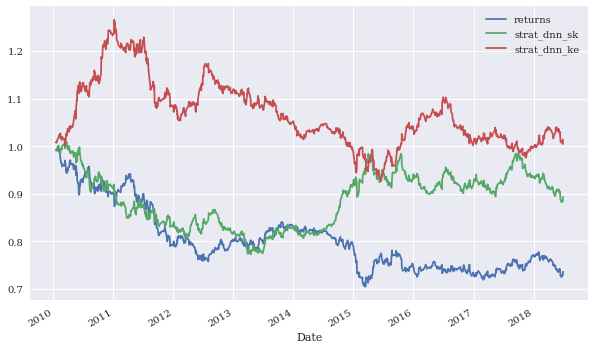

In [179]:
test[['returns', 'strat_dnn_sk', 'strat_dnn_ke']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_15.png');